In [1]:
import torch
import random
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import huffman
import math
import faiss
import sys
sys.path.insert(1, '../core')
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import warnings
warnings.filterwarnings('ignore')


# CIFAR-10 Experiments: Symbolic Inference using ImageNet codebook

In [2]:
# Basic definitions for CIFAR-10 inference
batch_size = 1
#  From my training code
random_seed = 1 

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Change the dataset folder to the proper location in a new system
testset_cifar = torchvision.datasets.CIFAR10(root='../../dataset', train=False, download=True, transform=transform_test)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size, shuffle=False)
testloader_std_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=64, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
from modeldefs import *

# Base model for Cifar-10 (data [0,1]) 
pretrained_base_gradinit = './cifar10_resnet_gradinit_best_day1.pt'
model_base_gradinit = resnet20()
model_base_gradinit.load_state_dict(torch.load(pretrained_base_gradinit))
model_base_gradinit.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [4]:
# Lets check the kind of prediction the model is doing - the standard non symbolic infrence
def cifar_test_base_acc(model):
    base_gradinit_clean = 0
    total = 0
    # Clean base gradinit inference   
    for images, labels in testloader_std_cifar:
        with torch.no_grad():
            X = images 
            y = labels
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    base_gradinit_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(base_gradinit_clean / total) 

In [7]:
print(" ******++++++++++++++============= Clean base gradinit (scaled data [0,1]) model inference ================+++++++++++******")
acc = cifar_test_base_acc(model_base_gradinit)
print("Base Non symbolic Grad init model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Clean base gradinit (scaled data [0,1]) model inference ================+++++++++++******
Base Non symbolic Grad init model Accuracy:91.34


In [7]:
# Lets check the kind of prediction the model is doing - the symbolic infrence
def cifar_test_sym_acc(model, n_clusters, index, centroid_lut, pdf , patch_size, stride, channel_count):
    sym_gradinit_clean = 0
    total = 0
    ana=False 
    multi=False
    instr = True
    # Sym base gradinit inference   
    for images, labels in testloader_cifar:
        with torch.no_grad():
            X = images 
            y = labels
            Xsym_, pdf = fm_to_symbolic_fm(X.squeeze(), n_clusters, index, centroid_lut, patch_size, stride, channel_count, ana, multi, instr, pdf)
            Xsym = torch.from_numpy(Xsym_)
            Xsym = Xsym.unsqueeze(0)
            output = model.forward(Xsym.float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    sym_gradinit_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(sym_gradinit_clean / total), pdf

In [5]:
import faiss
from patchutils import *
patch_size = (2, 2)
channel_count = 3
stride = 0

In [8]:
index = faiss.read_index("./kmeans_img_k2_s0_c2048_v0.index")
n_clusters=2048
pdf_2048 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit model inference (symbols / clusters: 2048) ================+++++++++++******")
acc, pdf_2048 = cifar_test_sym_acc(model_base_gradinit, n_clusters, index, centroid_lut, pdf_2048 , patch_size, stride, channel_count)
print("Symbolic Grad init model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit model inference (symbols / clusters: 2048) ================+++++++++++******
Symbolic Grad init model Accuracy:89.19


In [11]:
index = faiss.read_index("../imagenet/kmeans_img_imgnet_k2_s0_c2048_v0.index")
n_clusters=2048
pdf_2048 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit model inference (symbols / clusters: 2048) ================+++++++++++******")
acc, pdf_2048 = cifar_test_sym_acc(model_base_gradinit, n_clusters, index, centroid_lut, pdf_2048 , patch_size, stride, channel_count)
print("Symbolic Grad init model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit model inference (symbols / clusters: 2048) ================+++++++++++******
Symbolic Grad init model Accuracy:88.73


In [39]:
def patch_vizualise(filter_mat, use_all=True, channel=1, num_rows=9):
    
    filter_mat = filter_mat.reshape(-1, 1, 2, 2)    
    num_rows = num_rows
    num_cols = filter_mat.shape[0] // num_rows 
    # make grid to display our images
    filter_grid = utils.make_grid(filter_mat, nrow=num_rows, normalize=True, padding=1, pad_value=255)
    #print(filter_grid.shape)
    plt.figure( figsize=(num_rows,num_cols) )
    # reshape and plot (because MPL needs channel as the last dimension)
    plt.imshow(filter_grid.numpy().transpose((1, 2, 0)))

In [7]:
# Small hack in Jupyter
plt.rcParams['figure.figsize'] = [12, 36]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


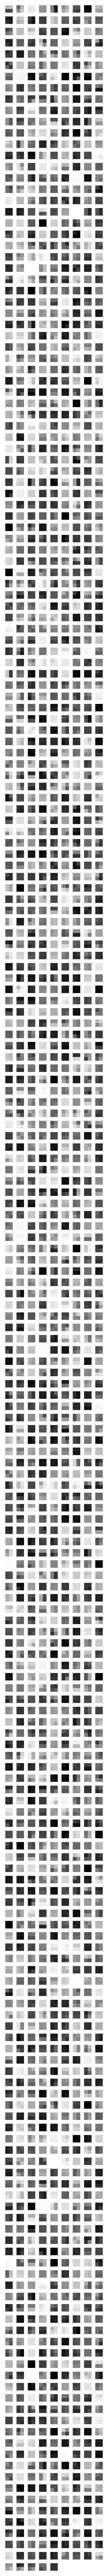

In [42]:
# print(centroid_lut[:81,:])
filter_mat = torch.from_numpy(centroid_lut)
patch_vizualise(filter_mat,use_all=True, num_rows=9)
plt.axis('off')
plt.ioff()
plt.show()

## Compare this against the filters learned in standard CNNs

In [2]:
def filter_vizualise(filter_mat, use_all=True, channel=1, num_rows=6):
    n, c, w, h = filter_mat.shape
    print(filter_mat.shape)
    if use_all:
        filter_mat = filter_mat.view(n*c, -1, w, h)
        print(filter_mat.shape)
    else:
        filter_mat = filter_mat[:,channel,:,:].unsqueeze(dim=1)

    num_rows = num_rows
    # For paper vizualization
    #num_rows = 9

    num_cols = filter_mat.shape[0] // num_rows 
    #num_cols = 9
    print(num_cols)
    # make grid (2 rows and 5 columns) to display our 10 images
    filter_grid = utils.make_grid(filter_mat, nrow=num_rows, normalize=True, padding=1, pad_value=255)
    print(filter_grid.shape)
    plt.figure( figsize=(num_rows,num_cols) )
    # reshape and plot (because MPL needs channel as the last dimension)
    plt.imshow(filter_grid.numpy().transpose((1, 2, 0)))

In [4]:
import torchvision.models as models
from torchvision import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

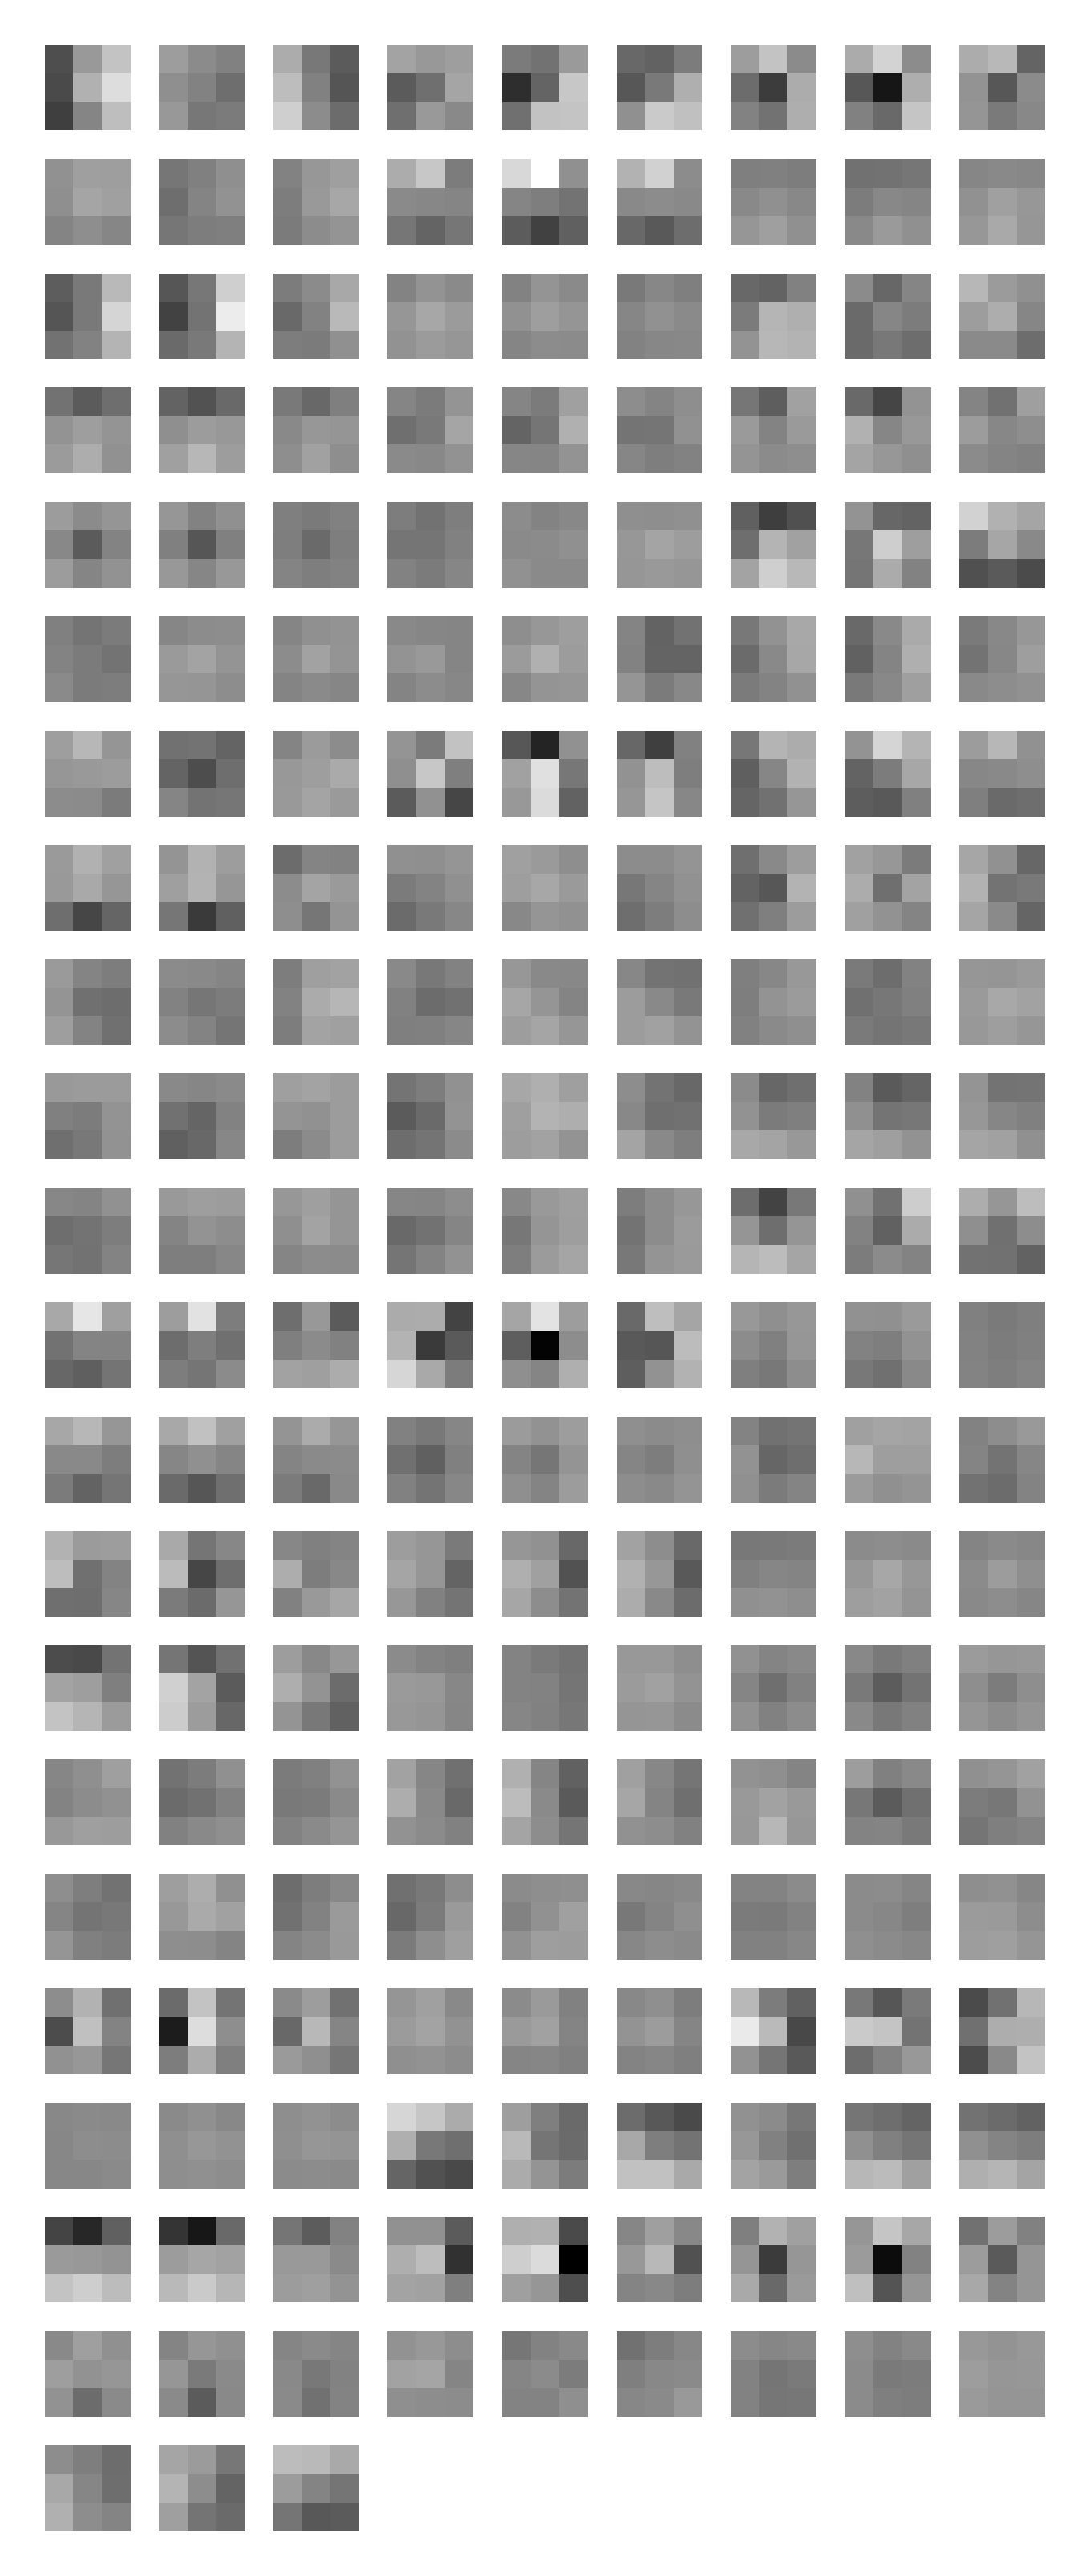

In [8]:

vgg_model= models.vgg16(pretrained=True)
print(vgg_model.features)
layer = 0
filter_mat = vgg_model.features[layer].weight.data.clone()
filter_vizualise(filter_mat,use_all=True, num_rows=9)
plt.axis('off')
plt.ioff()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 3, 3])
torch.Size([96, 1, 3, 3])
10
torch.Size([3, 45, 37])


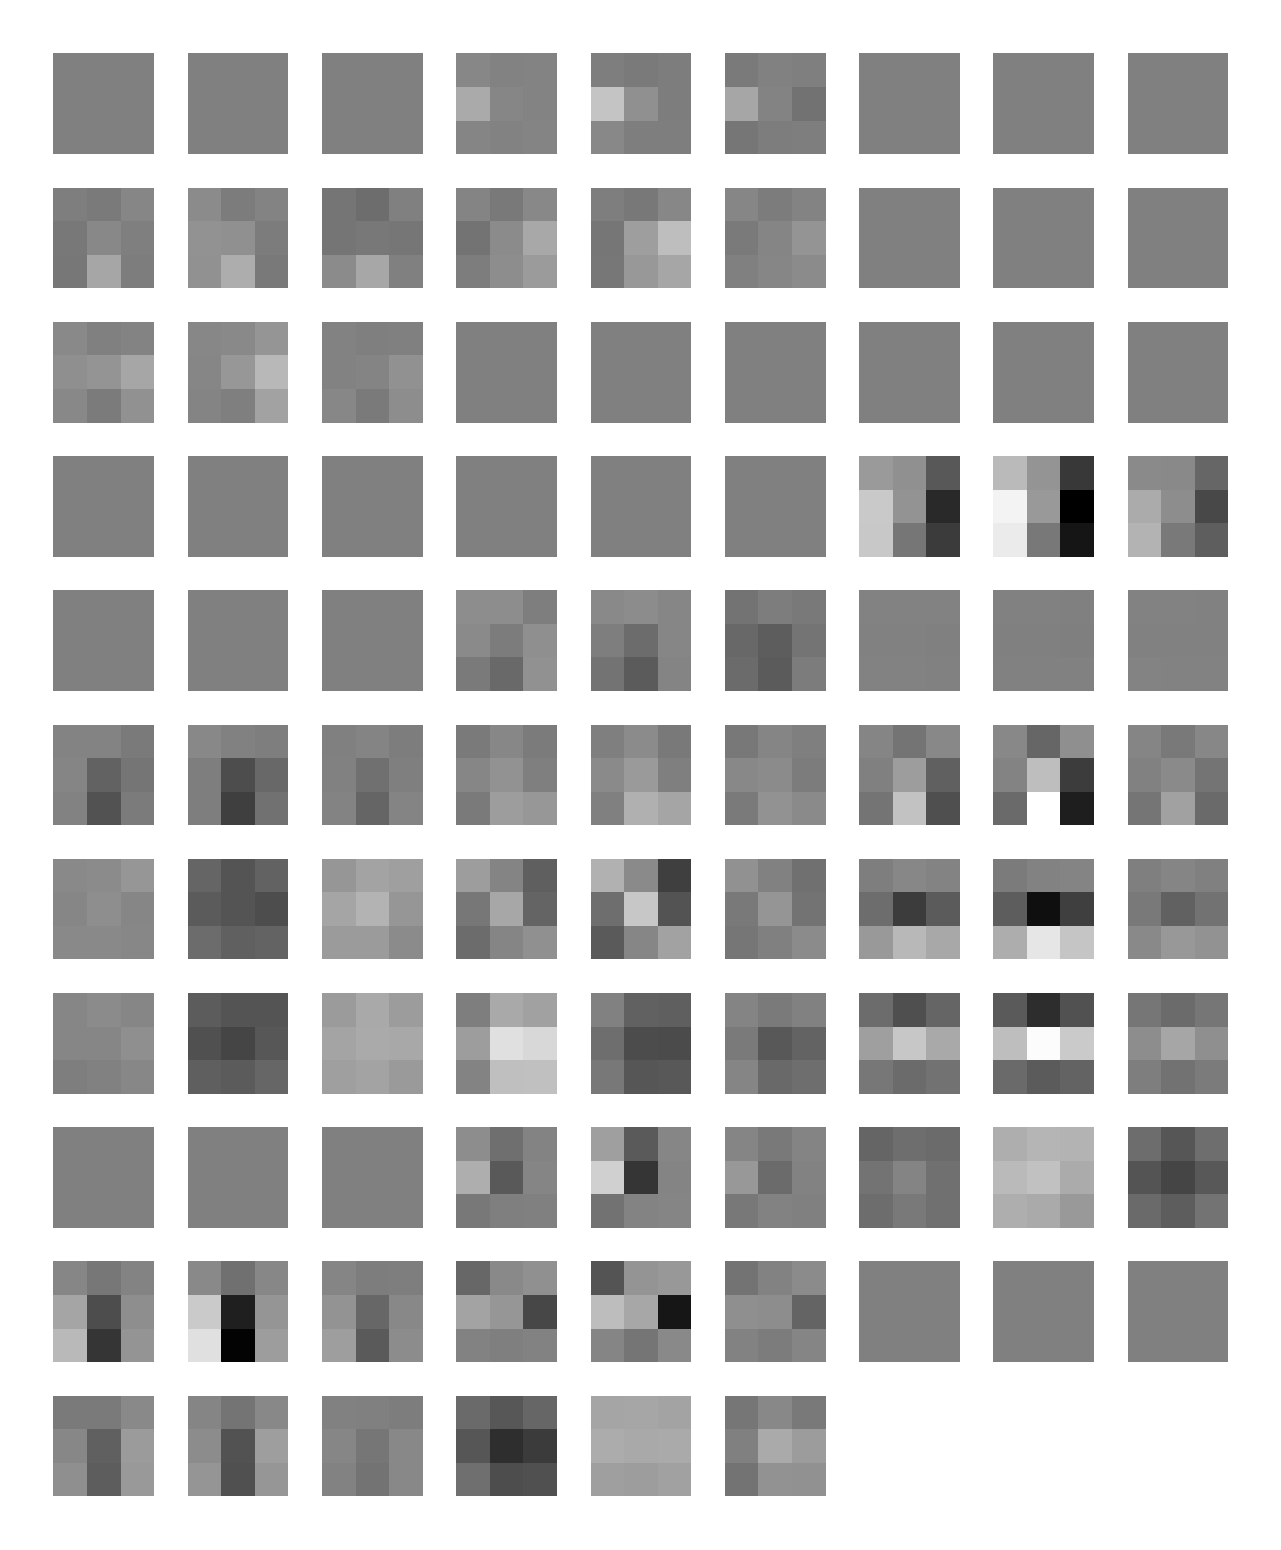

In [9]:
model_mnasnet1_0 = models.mnasnet1_0(pretrained=True)
filter_mat = model_mnasnet1_0.layers[0].weight.data.clone()
filter_vizualise(filter_mat,use_all=True, num_rows=9)
plt.axis('off')
plt.ioff()
plt.show()